In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq

In [40]:
ndim = 2
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

If tensor has more than 2 dimensions, only diagonal of covariance is returned


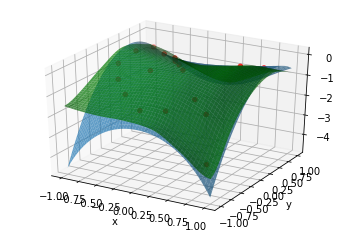

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)

xys = (2*(sobol_seq.i4_sobol_generate(2,20)-0.5)) #[-1,1] cube
zs = exponential_quartic(xys)
ax.scatter(xys[:,0],xys[:,1],zs,color='red')
ax.set_xlabel('x');
ax.set_ylabel('y');

gp = bvbq.gp.SimpleGP(2,kind='smatern32',noise=0)
gp.set_data(xys,zs,empirical_params=True)
gp.optimize_params()
Zreg = gp.predict(np.stack([X,Y],axis=-1))[0]
ax.plot_surface(X,Y,Zreg,alpha=0.7,color='green')

In [179]:
def monte_carlo_bayesian_quadrature(gp,distrib,nsamples):
    samples1 = distrib.sample(nsamples)
    samples2 = distrib.sample(nsamples)
    samples3 = distrib.sample(nsamples)
    z = gp.kernel_function(gp.X,samples1).mean(axis=-1,keepdims=True) #(m,1)
    gamma = gp.kernel_function(samples2,samples3,diagonal=True).mean()
    mean,var = calculate_bq_mean_var(gp,z,gamma)
    return mean,var

def false_monte_carlo_bayesian_quadrature(gp,distrib,nsamples):
    samples = distrib.sample(nsamples)
    mean = jnp.mean(gp.predict(distrib.sample(nsamples),return_cov=False))
    return mean

def calculate_bq_mean_var(gp,z,gamma):
    y_ = jax.scipy.linalg.solve_triangular(gp.upper_chol_matrix,
                                           gp.y-gp.mean,
                                           trans='T') #(m,1)
    z_ = jax.scipy.linalg.solve_triangular(gp.upper_chol_matrix,
                                           z,
                                           trans='T') #(m,1)
    mean = gp.mean + z_.transpose()@y_
    var = gamma - z_.transpose()@z_
    return mean,var

In [195]:
def separable_mvn_bq(gp,mean,var,nhermite=30):
    locs,weights = np.polynomial.hermite.hermgauss(nhermite)
    locs = jnp.array(locs,dtype=jnp.float32)
    weights = jnp.array(weights,dtype=jnp.float32)
    locs_ = locs.reshape(-1,1)*jnp.sqrt(var)*jnp.sqrt(2) + mean
    weights_ = jnp.expand_dims(weights,(-2,-1)) #(k,1,1)
    weights__ = jnp.expand_dims(weights,(0,-1)) #(1,k,1)
    
    xdata = gp.X
    kernel_tensor = bvbq.gp.kernelfunctions.kernel_function_separated(locs_,xdata,kind=gp.kind,
                                                      theta=gp.theta,
                                                      l=gp.lengthscale) #(k,n,d)
    kernel_tensor *= weights_ #(k,n,d)
    kernel_matrix = jnp.sum(kernel_tensor,axis=0)*1/jnp.sqrt(jnp.pi) #(n,d)
    z = jnp.prod(kernel_matrix,axis=-1,keepdims=True)
    print(z.shape)
    kernel_tensor_2 = bvbq.gp.kernelfunctions.kernel_function_separated(locs_,
                                                                        locs_,
                                                                        kind=gp.kind,
                                                                        theta=gp.theta,
                                                                        l=gp.lengthscale) #(k,k,d)
    kernel_tensor_2 *= weights_*weights__
    gamma = jnp.prod(1/jnp.pi*jnp.sum(jnp.sum(kernel_tensor_2,0),0))
    mean,var = calculate_bq_mean_var(gp,z,gamma)
    return mean,var

def separable_mixmvn_bq(gp,means,variances,weights,nhermite=30):
    hlocs,hweights = np.polynomial.hermite.hermgauss(nhermite)
    hlocs = jnp.array(hlocs,dtype=jnp.float32)
    hweights = jnp.array(hweights,dtype=jnp.float32)
    hlocs_ = jnp.expand_dims(hlocs,(-2,-1))*jnp.sqrt(variances)*jnp.sqrt(2) + means #(k,m,d)
    hweights_ = jnp.expand_dims(hweights,(-3,-2,-1)) #(k,1,1,1)
    hweights__ = jnp.expand_dims(hweights,(-2,-1)) #(k,1,1)
    hweights___ = jnp.expand_dims(hweights,(-4,-3,-2,-1)) #(k,1,1,1,1)
    xdata = gp.X
    kernel_tensor = bvbq.gp.kernelfunctions.kernel_function_separated(hlocs_,
                                                                      xdata,
                                                                      kind=gp.kind,
                                                                      theta=gp.theta,
                                                                      l=gp.lengthscale) #(k,m,n,d)
    kernel_tensor *= hweights_ #(k,m,n,d)
    kernel_matrices = jnp.sum(kernel_tensor,axis=0)*1/jnp.sqrt(jnp.pi) #(m,n,d)
    z = jnp.expand_dims(
                    jnp.sum(
                        jnp.prod(kernel_matrices,axis=-1)*\
                        jnp.expand_dims(weights,-1),
                     axis=0),-1) #(m,n,d) -> (n,d) -> (d,) -> (d,1)

    kernel_tensor_2 = bvbq.gp.kernelfunctions.kernel_function_separated(hlocs_,
                                                                        hlocs_,
                                                                        kind=gp.kind,
                                                                        theta=gp.theta,
                                                                        l=gp.lengthscale) #(k,m,k,m,d)
    kernel_tensor_2 *= hweights__*hweights___
    gamma_matrix = jnp.prod(1/jnp.pi*jnp.sum(jnp.sum(kernel_tensor_2,0),1),-1)
    gamma = jnp.sum(gamma_matrix*weights*jnp.expand_dims(weights,-1))
    gamma = jnp.sum(gamma_matrix*weights*jnp.expand_dims(weights,-1))
    mean,var = calculate_bq_mean_var(gp,z,gamma)
    return mean,var

In [219]:
mean = jnp.zeros(2)
var = jnp.ones(2)
distrib = bvbq.distributions.DiagonalNormalDistribution(jnp.zeros(2),jnp.ones(2))

In [221]:
print(monte_carlo_bayesian_quadrature(gp,distrib,10000))
print(separable_mvn_bq(gp,mean,var))
print(bvbq.bq.separable_mvn_bq(gp,mean,var))

(DeviceArray([[-0.9801225]], dtype=float32), DeviceArray([[0.01448594]], dtype=float32))
(20, 1)
(DeviceArray([[-0.9840447]], dtype=float32), DeviceArray([[0.01307289]], dtype=float32))
(DeviceArray([[-0.9840447]], dtype=float32), DeviceArray([[0.01307289]], dtype=float32))


In [211]:
means = jax.random.normal(jax.random.PRNGKey(100),shape=(3,2))
variances = jnp.exp(jax.random.normal(jax.random.PRNGKey(50),shape=(3,2)))
weights = jnp.array(np.random.dirichlet((1,)*3),dtype=jnp.float32)
distrib = bvbq.distributions.MixtureDiagonalNormalDistribution(means,variances,weights)

In [213]:
print(monte_carlo_bayesian_quadrature(gp,distrib,10000))
print(separable_mixmvn_bq(gp,means,variances,weights))
print(bvbq.bq.separable_mixmvn_bq(gp,means,variances,weights))

(DeviceArray([[-0.88067484]], dtype=float32), DeviceArray([[0.0273761]], dtype=float32))
(DeviceArray([[-0.89120847]], dtype=float32), DeviceArray([[0.0269903]], dtype=float32))
(DeviceArray([[-0.89120847]], dtype=float32), DeviceArray([[0.0269903]], dtype=float32))


In [210]:
bvbq.bq.separable_mixmvn_bq(gp,means,variances,weights)

(DeviceArray([[-0.9673939]], dtype=float32),
 DeviceArray([[0.04669301]], dtype=float32))

In [204]:
z_vectors.shape

(20, 1)

In [178]:
gamma

DeviceArray(0.08051841, dtype=float32)

In [101]:
locs,weights = np.polynomial.hermite.hermgauss(30)
locs = jnp.array(locs,dtype=jnp.float32)
weights = jnp.array(weights,dtype=jnp.float32)
locs_ = locs.reshape(-1,1)*jnp.sqrt(var)*jnp.sqrt(2) + mean
weights_ = jnp.expand_dims(weights,(-2,-1)) #(k,1,1)
weights__ = jnp.expand_dims(weights,(0,-1)) #(1,k,1)
xdata = gp.X
kernel_tensor = bvbq.gp.kernelfunctions.kernel_function_separated(locs_,xdata,kind=gp.kind,
                                                  theta=gp.theta,
                                                  l=gp.lengthscale) #(k,n,d)
kernel_tensor *= weights_ #(k,n,d)
kernel_matrix = jnp.sum(kernel_tensor,axis=-1)*1/jnp.sqrt(jnp.pi) #(n,d)
z = jnp.prod(kernel_matrix,axis=-1,keepdims=True) #(n,)

kernel_tensor_2 = bvbq.gp.kernelfunctions.kernel_function_separated(locs_,
                                                                    locs_,
                                                                    kind=gp.kind,
                                                                    theta=gp.theta,
                                                                    l=gp.lengthscale) #(k,k,d)
kernel_tensor_2 *= weights_*weights__
gamma = jnp.prod(1/jnp.pi*jnp.sum(jnp.sum(kernel_tensor_2,0),0))